Enter the known flight altitude:  62
Enter the path to the folder containing images:  E:\Shwetabh\testing\VO\sa


Not enough matches found for frame 1
Not enough matches found for frame 28
Not enough matches found for frame 29
Not enough matches found for frame 30
Not enough matches found for frame 31
Not enough matches found for frame 32
Not enough matches found for frame 33
Not enough matches found for frame 34
Optimized Trajectory (x, y, z):
Pose 0: [0. 0. 0.]
Pose 1: [0.36615075 0.37804915 0.81509966]
Pose 2: [0.95457047 0.88730307 2.02489536]
Pose 3: [1.00790602 1.86241792 1.98998489]
Pose 4: [0.96503137 2.5005709  2.49708236]
Pose 5: [1.09950054 3.21567268 2.90560348]
Pose 6: [2.0755175  3.54127928 1.54814985]
Pose 7: [ 2.39795568  3.48435374 -0.02224159]
Pose 8: [ 3.42629743  3.53644635 -0.16285277]
Pose 9: [ 0.41456385 -1.36728774 -4.47120818]
Pose 10: [ 0.86400028 -2.18592282 -3.16555563]
Pose 11: [ 0.82671385 -2.58742976 -3.05125971]
Pose 12: [ 0.81714909 -3.08190204 -3.5076621 ]
Pose 13: [ 0.18061899 -3.42612829 -2.07921663]
Pose 14: [ 0.1828358  -3.76241471 -2.37139446]
Pose 15: [-0.57

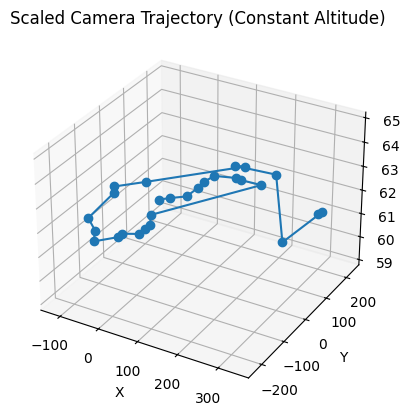

Scaled trajectory saved to scaled_camera_trajectory.csv


In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, least_squares
import csv
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from scipy.sparse import lil_matrix
#functions

def orb_detector_descriptor(image):
    orb = cv2.ORB_create(nfeatures=2000)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors

def is_keyframe(current_kp, last_keyframe_kp, min_matches=100):
    if len(last_keyframe_kp) == 0:
        return True
    return len(current_kp) >= min_matches

def refine_E(E, p1, p2, K):
    def objective(E_vec):
        E_mat = E_vec.reshape(3, 3)
        p1_norm = cv2.undistortPoints(p1.reshape(-1, 1, 2), K, None).reshape(-1, 2)
        p2_norm = cv2.undistortPoints(p2.reshape(-1, 1, 2), K, None).reshape(-1, 2)
        error = 0
        for i in range(len(p1_norm)):
            p1_homogeneous = np.append(p1_norm[i], 1)
            p2_homogeneous = np.append(p2_norm[i], 1)
            error += np.abs(np.dot(p2_homogeneous, np.dot(E_mat, p1_homogeneous)))
        return error

    result = minimize(objective, E.flatten(), method='Nelder-Mead')
    return result.x.reshape(3, 3)

def motion_only_bundle_adjustment(R, t, points_3d, points_2d, K):
    def project(points_3d, rvec, tvec, K):
        points_proj, _ = cv2.projectPoints(points_3d, rvec, tvec, K, None)
        return points_proj.reshape(-1, 2)

    def objective(params):
        rvec, tvec = params[:3], params[3:]
        points_proj = project(points_3d, rvec, tvec, K)
        return (points_proj - points_2d).ravel()

    rvec, _ = cv2.Rodrigues(R)
    params = np.hstack((rvec.ravel(), t.ravel()))
    result = least_squares(objective, params)
    
    R_opt, _ = cv2.Rodrigues(result.x[:3])
    t_opt = result.x[3:].reshape(3, 1)
    
    return R_opt, t_opt

def detect_loop_closures(trajectory, descriptors, distance_threshold=5.0, similarity_threshold=0.7):
    loop_closures = []
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    nn.fit(trajectory)
    
    for i in range(len(trajectory)):
        distances, indices = nn.kneighbors([trajectory[i]])
        for j, distance in zip(indices[0], distances[0]):
            if j > i + 10 and distance < distance_threshold:  # Avoid consecutive frames
                # Check descriptor similarity
                matches = flann.knnMatch(descriptors[i], descriptors[j], k=2)
                good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
                if len(good_matches) / len(matches) > similarity_threshold:
                    loop_closures.append((i, j))
    
    return loop_closures

def create_pose_graph(trajectory, loop_closures):
    g = nx.Graph()
    for i in range(len(trajectory) - 1):
        g.add_edge(i, i+1, weight=1)
    
    for i, j in loop_closures:
        g.add_edge(i, j, weight=0.1)  # Lower weight for loop closures
    
    return g

def optimize_pose_graph(trajectory, pose_graph):
    n = len(trajectory)
    
    def objective(x):
        residuals = []
        for u, v, data in pose_graph.edges(data=True):
            p1 = x[u*3:u*3+3]
            p2 = x[v*3:v*3+3]
            weight = data['weight']
            residuals.append((p2 - p1) * weight)
        return np.concatenate(residuals)
    
    x0 = trajectory.flatten()
    res = least_squares(objective, x0)
    return res.x.reshape(-1, 3)

def scale_trajectory_constant_altitude(trajectory, known_altitude):
    """
    Scale the trajectory assuming a constant flight altitude.
    """
    # Find the average z-coordinate in the current trajectory
    avg_z = np.mean(trajectory[:, 2])
    
    # Calculate the scale factor
    scale_factor = known_altitude / avg_z if avg_z != 0 else 1
    
    # Scale the trajectory
    scaled_trajectory = trajectory * scale_factor
    
    # Set all z-coordinates to the known altitude
    scaled_trajectory[:, 2] = known_altitude
    
    return scaled_trajectory

###################################################################################################################################################
K = np.array([
    [4085.11, 0, 3000],
    [0, 4102.56, 2000],
    [0, 0, 1]
])
known_altitude = float(input("Enter the known flight altitude: "))
#images
image_folder = input("Enter the path to the folder containing images: ")
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg') or f.endswith('.png')])

images = []
gray_images = []
keypoints = []
descriptors = []

for image_file in image_files:
    img_path = os.path.join(image_folder, image_file)
    img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    images.append(img)
    gray_images.append(gray_img)
    
    k, d = orb_detector_descriptor(gray_img)
    keypoints.append(k)
    descriptors.append(d)

# FLANN matcher
FLANN_INDEX_LSH = 6
index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Calculate camera trajectory
R_total = np.eye(3)
t_total = np.zeros((3, 1))
# Initialize trajectory and descriptors
trajectory = [np.zeros(3)]  # Start at origin
all_descriptors = [descriptors[0]]  # Store all descriptors for loop closure

last_keyframe_kp = keypoints[0]
last_keyframe_desc = descriptors[0]
last_keyframe_index = 0

R_total = np.eye(3)
t_total = np.zeros((3, 1))

for i in range(1, len(images)):
    
    if is_keyframe(keypoints[i], last_keyframe_kp):
        matches = flann.knnMatch(last_keyframe_desc, descriptors[i], k=2)
        good_matches = []
        for match in matches:
            if len(match) == 2:
                m, n = match
                if m.distance < 0.7 * n.distance:
                    good_matches.append(m)
        # If only one match is found, we could either skip it or add it conditionally
        # elif len(match) == 1:
        #     good_matches.append(match[0])

        if len(good_matches) > 10:
            p1 = np.float32([keypoints[last_keyframe_index][m.queryIdx].pt for m in good_matches])
            p2 = np.float32([keypoints[i][m.trainIdx].pt for m in good_matches])

            E, mask = cv2.findEssentialMat(p1, p2, K, method=cv2.RANSAC, prob=0.999, threshold=0.5)
            E_refined = refine_E(E, p1, p2, K)
            _, R, t, mask = cv2.recoverPose(E_refined, p1, p2, K)

            # Triangulate points
            points_4d = cv2.triangulatePoints(K @ np.hstack((np.eye(3), np.zeros((3, 1)))),
                                              K @ np.hstack((R, t)),
                                              p1.T, p2.T)
            points_3d = (points_4d[:3] / points_4d[3]).T

            # Motion-only Bundle Adjustment
            R_opt, t_opt = motion_only_bundle_adjustment(R, t, points_3d, p2, K)

            R_total = R_opt @ R_total
            t_total = R_opt @ t_total + t_opt

            trajectory.append(t_total.flatten())
            all_descriptors.append(descriptors[i])

            # Perform loop closure detection and optimization every N frames
            if len(trajectory) % 20 == 0:
                loop_closures = detect_loop_closures(trajectory, all_descriptors)
                if loop_closures:
                    print(f"Loop closures detected: {loop_closures}")
                    pose_graph = create_pose_graph(trajectory, loop_closures)
                    optimized_trajectory = optimize_pose_graph(np.array(trajectory), pose_graph)
                    
                    scaled_trajectory = scale_trajectory_constant_altitude(optimized_trajectory, known_altitude)
        
                    # Update the trajectory and total transformation
                    trajectory = list(scaled_trajectory)
                    R_total, _ = cv2.Rodrigues(scaled_trajectory[-1] - scaled_trajectory[-2])
                    t_total = scaled_trajectory[-1].reshape(3, 1)

            last_keyframe_kp = keypoints[i]
            last_keyframe_desc = descriptors[i]
            last_keyframe_index = i

        else:
            print(f"Not enough matches found for frame {i}")

    else:
        print(f"Frame {i} is not a keyframe")

trajectory = np.array(trajectory)
final_scaled_trajectory = scale_trajectory_constant_altitude(trajectory, known_altitude)

# Print out the trajectory
print("Optimized Trajectory (x, y, z):")
for i, position in enumerate(trajectory):
    print(f"Pose {i}: {position}")

"""
# Save trajectory to a CSV file
output_file = "optimized_camera_trajectory.csv"
with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Pose', 'X', 'Y', 'Z'])  # Header
    for i, position in enumerate(trajectory):
        csv_writer.writerow([i, position[0], position[1], position[2]])

print(f"Optimized trajectory saved to {output_file}")
"""

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(final_scaled_trajectory[:, 0], final_scaled_trajectory[:, 1], final_scaled_trajectory[:, 2], marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Scaled Camera Trajectory (Constant Altitude)')

# Save the plot as an image
plot_file = "scaled_camera_trajectory_plot.png"
plt.savefig(plot_file)
print(f"Scaled trajectory plot saved to {plot_file}")

plt.show()

# Save scaled trajectory to a CSV file
output_file = "scaled_camera_trajectory.csv"
with open(output_file, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['Pose', 'X', 'Y', 'Z'])  # Header
    for i, position in enumerate(final_scaled_trajectory):
        csv_writer.writerow([i, position[0], position[1], position[2]])

print(f"Scaled trajectory saved to {output_file}")

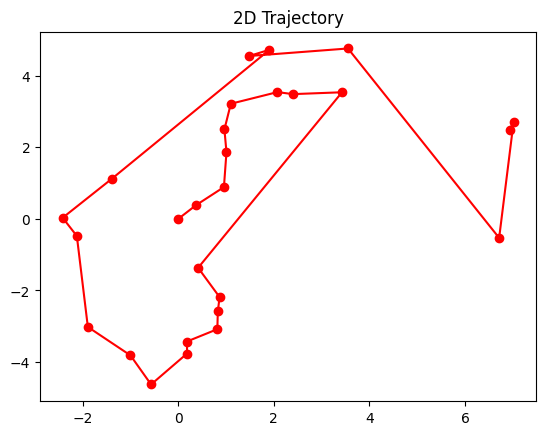

In [2]:
plt.figure()
plt.plot(trajectory[:, 0], trajectory[:, 1],'ro-')
plt.title('2D Trajectory')
plt.show()